(160, 320, 3)


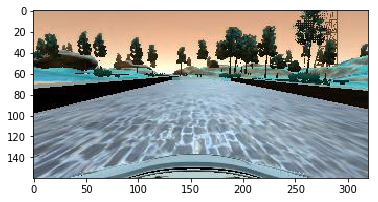

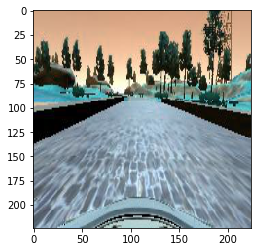

[[[208 163 130]
  [208 163 130]]

 [[208 163 130]
  [208 163 130]]]
[[[ 0.31568627  0.13921569  0.00980392]
  [ 0.31568627  0.13921569  0.00980392]]

 [[ 0.31568627  0.13921569  0.00980392]
  [ 0.31568627  0.13921569  0.00980392]]]


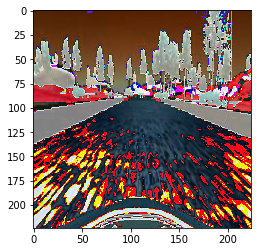

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

name = './data/IMG/center_2016_12_01_13_30_48_287.jpg'
image = cv2.imread(name)
print(np.shape(image))
plt.imshow(image)
plt.show()

#image = image[65:135, 0:320]
#print(np.shape(image))
#plt.imshow(image)
#plt.show()

image = cv2.resize(image, (224, 224))
plt.imshow(image)
plt.show()

print(image[:2,:2])
image = image / 255.0 - 0.5
print(image[:2,:2])
plt.imshow(image)
plt.show()

In [2]:
############################################################################
# Get bottleneck features of ResNet50
############################################################################
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import logging
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras import applications

logger = logging.getLogger()
logger.setLevel(logging.INFO) #logging.INFO logging.DEBUG
if logger.handlers == []:
    ch = logging.StreamHandler()
    logger.addHandler(ch)

# Load training data (image file name + steering) from csv file
samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if line[0] == 'center':  # exclude the header line
            continue
        samples.append(line)
        
with open('./record_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if line[0] == 'center':  # exclude the header line
            continue
        samples.append(line)

# Split 20% data as validation samples
train_samples, validation_samples = train_test_split(samples, test_size=0.1)
logger.info('number of training samples {}'.format(len(train_samples)))
logger.info('number of validation samples {}'.format(len(validation_samples)))

# Define variables for bottleneck feature generator
y_train = []
y_validation = []
batch_size = 64
train_steps = len(train_samples) // batch_size + 1
validation_steps = len(validation_samples) // batch_size + 1


# Define data generator
def bottleneck_feature_generator(samples, batch_size=64, 
                                 is_training=False, num_steps=None): 
    num_samples = len(samples)
    correction = 0.2
    
    for offset in range(0, num_samples, batch_size):
        if offset // batch_size == num_steps - 1:
            batch_size = num_samples - offset
        
        batch_samples = samples[offset:offset+batch_size]
        images = []
        angles = []
        for batch_sample in batch_samples:
            for i in range(3):
                try:
                    # Load image and steering angle
                    name = './data/IMG/'+batch_sample[i].split('/')[-1]
                    image = cv2.imread(name)                # load 
                    #image = image[65:135, 0:320]            # crop 
                    image = cv2.resize(image, (224, 224))   # resize
                    image = image / 255.0 - 0.5             # normalize
                    angle = float(batch_sample[3])
                    if i == 1:    # Left camera image steering correction
                        angle += correction 
                    elif i == 2:  # Right camera image steering correction
                        angle -= correction
                    images.append(image)
                    angles.append(angle)

                    # Data augmentation by flipping if in training mode
                    if is_training:
                       images.append(cv2.flip(image, 1))
                       angles.append(angle * -1.0)
                except Exception as e:
                    logger.debug("")
                    logger.debug(name)
                    logger.debug(str(e))
                    logger.debug("")

        X_augmented = np.array(images)
        y_augmented = np.array(angles)

        logger.debug('X_augmented {}'.format(np.shape(X_augmented)))
        logger.debug('y_augmented {}'.format(np.shape(y_augmented)))
        
        if is_training == True:
            global y_train
            y_train = np.append(y_train, y_augmented)                
            logger.debug('y_train {}'.format(np.shape(y_train)))
        else:
            global y_validation
            y_validation = np.append(y_validation, y_augmented)
            logger.debug('y_validation {}'.format(np.shape(y_validation)))

        yield X_augmented
                

# Build the ResNet50 network
model = applications.resnet50.ResNet50(include_top=False, weights='imagenet')

# Create data generator for training set and validation set
train_generator = bottleneck_feature_generator(train_samples, batch_size=64, is_training=True, num_steps=train_steps)
validation_generator = bottleneck_feature_generator(validation_samples, batch_size=64, num_steps=validation_steps)

# Get bottleneck features of training set and validation set
X_train = model.predict_generator(train_generator, train_steps, verbose=1)
np.save(open('bottleneck_features_train.npy', 'wb'), X_train)
np.save(open('bottleneck_labels_train.npy', 'wb'), y_train)
logger.info('')
logger.info('X_train {}'.format(np.shape(X_train)))
logger.info('y_train {}'.format(np.shape(y_train)))
logger.info('')

X_validation = model.predict_generator(validation_generator, validation_steps, verbose=1)
np.save(open('bottleneck_features_validation.npy', 'wb'), X_validation)
np.save(open('bottleneck_labels_validation.npy', 'wb'), y_validation)
logger.info('')
logger.info('X_validation {}'.format(np.shape(X_validation)))
logger.info('y_validation {}'.format(np.shape(y_validation)))
logger.info('')

Using TensorFlow backend.
number of training samples 9265
number of validation samples 1030


145/145 [==============================] - 523s 4s/step



X_train (55590, 1, 1, 2048)
y_train (55590,)



17/17 [==============================] - 31s 2s/step



X_validation (3090, 1, 1, 2048)
y_validation (3090,)



model created

model compiled
X_train 434
X_validation 24
Hyperparameter combination 1
learning rate=1.00e-03, decay_rate=1.00e-02, batch size=128


Epoch 1/100
434/434 [==============================] - 3s 6ms/step - loss: 0.1027 - val_loss: 0.0354
Epoch 2/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0347 - val_loss: 0.0305
Epoch 3/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0315 - val_loss: 0.0278
Epoch 4/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0295 - val_loss: 0.0265
Epoch 5/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0280 - val_loss: 0.0250
Epoch 6/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0270 - val_loss: 0.0247
Epoch 7/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0261 - val_loss: 0.0236
Epoch 8/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0256 - val_loss: 0.0232
Epoch 9/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0249 - val_loss: 0.0227
Epoch 10/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0243 - val_lo

434/434 [==============================] - 2s 5ms/step - loss: 0.0180 - val_loss: 0.0177
Epoch 82/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0179 - val_loss: 0.0178
Epoch 83/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0179 - val_loss: 0.0176
Epoch 84/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0179 - val_loss: 0.0179
Epoch 85/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0179 - val_loss: 0.0177
Epoch 86/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0178 - val_loss: 0.0177
Epoch 87/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0178 - val_loss: 0.0176
Epoch 88/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0179 - val_loss: 0.0176
Epoch 89/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0178 - val_loss: 0.0177
Epoch 90/100
434/434 [==============================] - 2s 5ms/step - loss: 0.0178 - val_loss: 

model trained
Best model so far. Model saved.

Result list (sorted by validation accuracy)
learning rate=1.00e-03, decay_rate=1.00e-02, batch size=128, train loss=0.018, validation loss=0.018


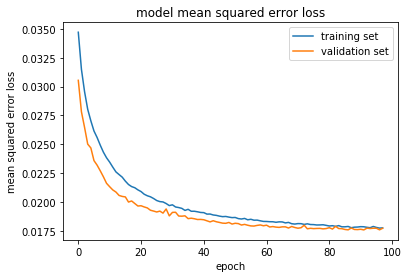

final model saved


In [4]:
############################################################################
# Transfer learning with ResNet bottleneck features
############################################################################
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import logging
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Input, Dropout
from keras import optimizers
import tensorflow as tf

logger = logging.getLogger()
logger.setLevel(logging.INFO) #logging.INFO logging.DEBUG
if logger.handlers == []:
    ch = logging.StreamHandler()
    logger.addHandler(ch)

# Define transfer learning generator
def transfer_learning_generator(X_samples, y_samples, batch_size=64):
    num_samples = len(X_samples)    
    while 1: # Loop forever so the generator never terminates until fit ends
        shuffle(X_samples, y_samples)
        for offset in range(0, num_samples, batch_size):
            batch_X = X_samples[offset:offset+batch_size]
            batch_y = y_samples[offset:offset+batch_size]
            if len(batch_X) != batch_size or len(batch_y) != batch_size:
                logger.debug('X_sampels {}'.format(len(X_samples)))
                logger.debug('offset {} batch_size {}'.format(offset, batch_size))
                logger.debug('offset // batch_size {}'.format(offset // batch_size))
                logger.debug('batch_X {}'.format(len(batch_X)))
                logger.debug('batch_y {}'.format(len(batch_y)))
                continue
            yield batch_X, batch_y

# Load Bottleneck features from files
X_train = np.load('bottleneck_features_train.npy')
y_train = np.load('bottleneck_labels_train.npy')
X_validation = np.load('bottleneck_features_validation.npy')
y_validation = np.load('bottleneck_labels_validation.npy')
            
# Hyperparameters
#learning_rates = 10 ** np.random.uniform(0, 2, 10)
learning_rates = [1e-3]
decay_rates = [1e-2]
batch_sizes = [128]  
dropout_rate = 0.3
num_epoch = 100

# model and history object of various hyperparameters combinations
hyperparameter_dict = {}
best_model = None
best_model_history = None

# Create NVIDIA model
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(256))
model.add(Dense(16))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

logger.info('model created')

# Hyperparameter tuning
counter = 0
for lr in learning_rates:
    for dr in decay_rates:
        for bs in batch_sizes:
            # Counter of hyperparameter combinations
            counter += 1
            
            # Compile model with selected loss function and optimizer
            adam = optimizers.Adam(lr=lr, decay=dr)
            model.compile(loss='mse', optimizer=adam)
            logger.info('')
            logger.info('model compiled')
            
            # Define generator with certain batch size
            train_generator = transfer_learning_generator(X_train, y_train, batch_size=bs)
            validation_generator = transfer_learning_generator(X_validation, y_validation, batch_size=bs)
            
            logger.info('X_train {}'.format(len(X_train) // bs))
            logger.info('X_validation {}'.format(len(X_validation) // bs))
            
            # Use generate to train and evaluate model
            logger.info('Hyperparameter combination {}'.format(counter))
            logger.info('learning rate={:.2e}, decay_rate={:.2e}, batch size={}'.format(lr, dr, bs))
            history = model.fit_generator(train_generator, epochs=num_epoch, verbose=1,
                                          steps_per_epoch=len(X_train) // bs,
                                          validation_steps=len(X_validation) // bs,
                                          validation_data=validation_generator)
            logger.info('model trained')

            # Save object
            hyperparameter_dict[(lr, dr, bs)] = (history.history['loss'][num_epoch-1], 
                                                 history.history['val_loss'][num_epoch-1])
            if best_model == None or \
               history.history['val_loss'][num_epoch-1] < best_model_history.history['val_loss'][num_epoch-1]:
                best_model = model
                best_model_history = history
                logger.info('Best model so far. Model saved.')
                logger.info('')
            
# Sort and print result list
logger.info('Result list (sorted by validation accuracy)')
hyperparameter_dict = sorted(hyperparameter_dict.items(), key=lambda x:x[1][1])
for h in hyperparameter_dict:
    logger.info('learning rate={:.2e}, decay_rate={:.2e}, batch size={}, '
                'train loss={:.3f}, validation loss={:.3f}'
                .format(h[0][0], h[0][1], h[0][2], h[1][0], h[1][1]))

# Visualize training loss and validation loss of best model
plt.plot(best_model_history.history['loss'][1:-1])
plt.plot(best_model_history.history['val_loss'][1:-1])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

# Prepare for creating final model
preprocessing_model = Sequential()
#preprocessing_model.add(Cropping2D(cropping=((65, 25), (0,0)), input_shape=(160, 320, 3)))                   
preprocessing_model.add(Lambda(lambda x: tf.image.resize_images(x, size=(224, 224)), input_shape=(160, 320, 3))) 
preprocessing_model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(224, 224, 3)))                    
resnet_model = applications.resnet50.ResNet50(include_top=False, weights='imagenet')

# Create final model
image = Input(shape=(160, 320, 3))
resnet_input = preprocessing_model(image)
feature_input = resnet_model(resnet_input)
angle = best_model(feature_input)
final_model = Model(inputs=image, outputs=angle)

# Save final model
final_model.save('model.h5')
logger.info('final model saved')